#### **Main Transformer Architecture**

In [190]:
import torch
import torch.nn as nn
import math

##### **Different Layers of Transoformers**

**What Are Input Embeddings?**  
Think of each word like a unique number from a giant dictionary. But computers don't understand meaning from numbers like 451 (which could mean "cat" in our vocab).

So we turn that number into a vector of 512 real numbers — like this:
451 → [0.23, -1.2, 0.003, ..., 1.45]  ← vector of length 512

These vectors are learned, meaning the model figures out the best way to represent each word during training. That’s what an embedding is — a better, richer representation of a word.

In [191]:
class InputEmbeddings(nn.Module):

    def __init__(self, d_model:int, vocab_size:int):

        super().__init__()
        self.d_model = d_model         # Size of each vector (No. of features model wants to learn from each word) 
        self.vocab_size = vocab_size   # Total no. of words the model can understand
        self.embeddings = nn.Embedding(vocab_size, d_model)

    def forward(self,x):
        
        return self.embeddings(x) * math.sqrt(self.d_model)  # Returns the embeddings for each word
    
        # (batch, seq_len) -> (batch, seq_len, d_model)
        # Scale embeddings by sqrt(d_model) as scales up the vectors slightly, helps the initial values to in a good range

**Why Do We Need Positional Encoding?**
Transformers treat every word equally — they don’t know if “Your” comes before “cat” or after.
But in language, position matters:

“Your cat is cute” ≠ “Cat your is cute”

So, we add extra information to each word vector to help the model know the word’s position.

In [192]:
class PostitionalEncoding(nn.Module):

    def __init__(self, d_model:int, seq_len:int, dropout: float)  -> None:

        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)

        # Create a matrix of shape (seq_len, d_model) = Positional Encoding matrix
        pe = torch.zeros(seq_len, d_model)
        # Creating a vector of shape (seq_len) = Position Vector 
        position = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)  # Dim: (seq_len, 1)
        # Create a vector of shape d_model
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model)) # Represents - (10000 ** (2i / d_model)

        # Apply sine to even indices
        pe[:, 0::2] = torch.sin(position * div_term)  # Formula - sin(position * (10000 ** (2i / d_model))
        # Apply cosine to odd indices
        pe[:, 1::2] = torch.cos(position * div_term)

        # Adding batch dimension to positional Encoding
        pe = pe.unsqueeze(0)  # Dim: (1, seq_len, d_model)

        # Registering pe as a buffer, means it's not a parameter but should be saved with the model
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)  # Static Embeddings + Positional Embeddings
        # Adds fixed positional encodings (non-trainable) to the input word embeddings for each position in the sequence.
        # self.pe[:, :x.shape[1], :] slices the positional encodings to match the exact length of the sentence. Dim: (1, actual_seq_len, d_model)
        return self.dropout(x)

**What is Layer Normalization?**  
Layer Normalization normalizes the features of each input (sentence or word vector) across its embedding dimensions to stabilize and speed up training.

So you normalize — adjust the scores so they:  
have mean = 0  
and standard deviation = 1  
This helps the model learn faster and more reliably.

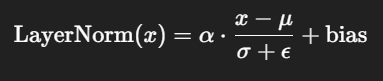



In [193]:
class LayerNormalization(nn.Module):

    def __init__(self, d_model:int, eps:float=1e-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(d_model))  # Learnable scaling factor (like a volume knob per feature)
        self.bias = nn.Parameter(torch.zeros(d_model))  # Learnable shifting factor (like an offset)

    def forward(self, x):
        # x represents i/p tensor of shape (batch, seq_len, d_model)
        mean = x.mean(dim=-1, keepdim=True) 
        std = x.std(dim=-1, keepdim=True)

        return self.alpha * (x-mean) / (std + self.eps) + self.bias

**Feed Forward Network-**  
The FeedForward block applies two linear layers with a ReLU and dropout in between to transform embeddings, first expanding and then compressing them, so the model can learn richer representations.

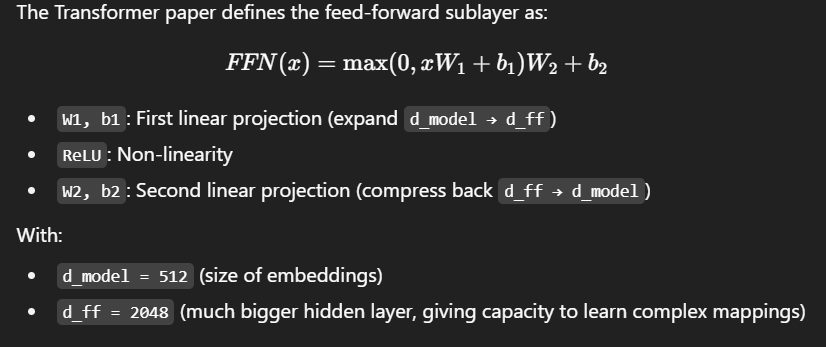

In [194]:
class FeedForword(nn.Module):

    def __init__(self, d_model:int, d_ff:int, dropout: float) -> None:
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),  # W1 & B1
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)   # W2 & B2
        )

    def forward(self, x):
        return self.ff(x)


**Residual Connections -**  
The ResidualConnection layer adds the original input back to the output of a sublayer (like attention or feedforward) after applying LayerNorm and Dropout, enabling better gradient flow and training stability.

**Why Use Residual (Skip) Connections?** 

**Without residuals, stacking many layers would:**  
Make gradients vanish (hard to train deep models)  
Cause the network to forget earlier representations  

**With residuals:**  
Information flows more easily across layers  
Model can learn corrections, rather than full transformations  
Makes the network deeper, but still trainable  



In [195]:
class ResidualConnection(nn.Module):

    def __init__(self, d_model:int, dropout:float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(d_model)

    def forward(self, x, sublayer):  # sublayer: Could be attention or feedforward block
        return x + self.dropout(sublayer(self.norm(x)))
    
    # Normalize x → smoother training
    #Pass it through the sublayer (sublayer(self.norm(x)))
    # Apply dropout
    # Add original input x back (residual connection)

**Multi-Head Attention-**  
Multi-head attention allows the model to attend to different parts of a sentence in parallel (capturing different context of a sentence) using multiple attention heads, and then combines their outputs into a single representation.

Each attention head learns to focus on different types of relationships between words. Then the model merges all those viewpoints into one combined understanding.

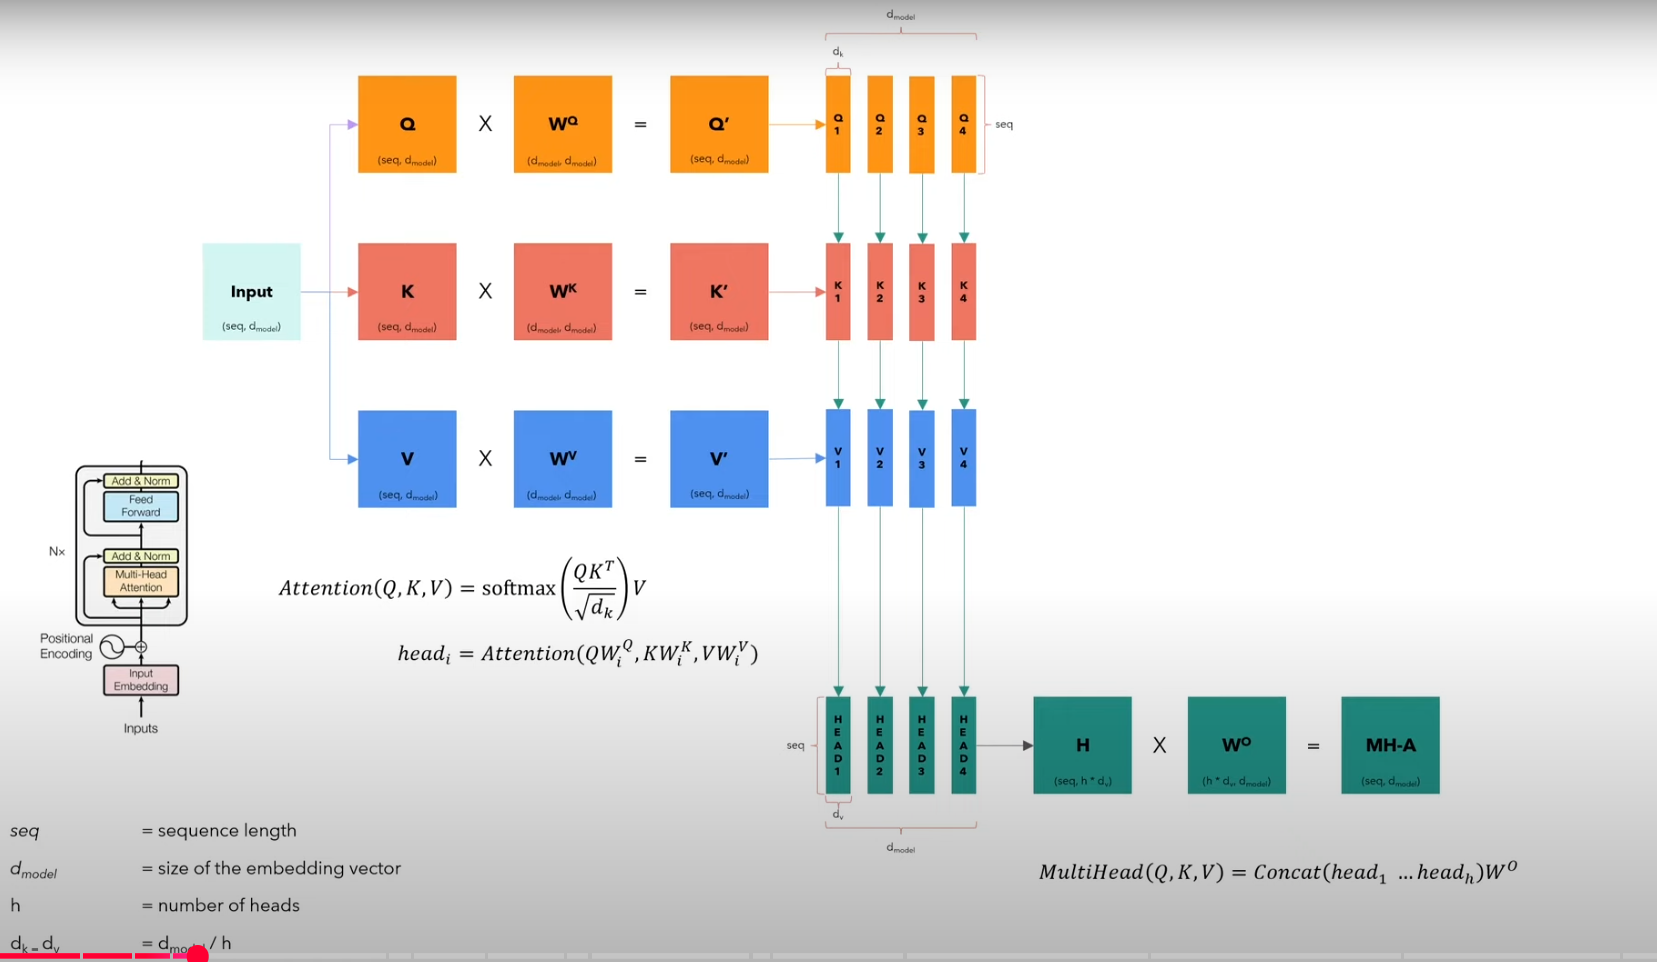

In [196]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model:int, h:int, dropout:float) -> None:

        super().__init__()
        self.d_model = d_model
        self.h = h  # No. of Heads
        self.dropout = nn.Dropout(dropout)
         
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # wo
        

    @staticmethod
    def attention(query, key, value, mask, dropout:nn.Dropout):
        d_k = query.shape[-1]  # d_k = dim of query 

        attention_scores = (query @ key.transpose(-2, -1))/ math.sqrt(d_k)  # Scaled Dot Product of Q & k

        if mask is not None:
            attention_scores = attention_scores.masked_fill_(mask==0, -1e9)  # Masking Future Tokens to avoid Data Leakage

        attention_scores = attention_scores.softmax(dim=-1)  # Softmax the scores to get the weights (w11,...)

        if dropout is not None:
            attention_scores = dropout(attention_scores)

        return (attention_scores @ value), attention_scores # Weighted sum of the Values (Contextual Embedding) & attention scores for Visualization
    

    def forward(self, q, k, v, mask):
        query = self.w_q(q)
        key = self.w_k(k)
        value = self.w_v(v)

        # Used view(batch, seq_len, h, d_k) to The 512-dimensional embedding vector is split into 8 heads, each handling a 64-dimensional slice. This reshapes the tensor from (batch, seq_len, 512) to (batch, seq_len, 8, 64), meaning each token now has 8 parallel representations, one per head, each working with part of the original vector.
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2)

        # Calculate Attention
        x, self.attention_scores = MultiHeadAttention.attention(query, key, value, mask, self.dropout)

        # This line merges all attention heads' outputs back into a single tensor of shape (batch, seq_len, d_model) after computing attention in parallel across heads.
        # .contiguous() - Ensures the tensor is stored in a continuous block of memory.Required before using .view() if you've changed dimensions using .transpose()
        x = x.transpose(1,2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply with Wo
        return self.w_o(x)  # Final Linear Layer to mix back the Heads Together
            

##### **Transformer Architecture**
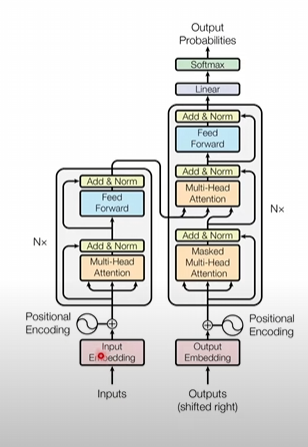

##### **Encoder-**
The EncoderBlock combines multi-head self-attention and feedforward layers with residual connections and normalization, and the Encoder stacks multiple such blocks sequentially before applying a final normalization.

x → LayerNorm → Self-Attention → Dropout → Add (residual)  
→ LayerNorm → FeedForward → Dropout → Add (residual)

**First residual connection:**  
Applies layer norm to x, then feeds into self_attention_block with query = key = value = x (self-attention)  
Adds the result back to original x

**Second residual connection:**  
Applies layer norm, then feed_forward_block  
Adds the result back to updated x

**nn.ModuleList -** nn.ModuleList is a PyTorch container that holds a list of submodules (like layers), allowing them to be registered and trained properly inside a custom nn.Module.

**Why Use nn.ModuleList?**
In PyTorch, if you want to store a list of layers, like multiple encoder blocks or residual connections, you must use nn.ModuleList — not a regular Python list.


i) The Encoder uses a mask to prevent the model from attending to padding tokens — not for causal (future-token) masking like the Decoder.

In [197]:
class EncoderBlock(nn.Module):

    def __init__(self, d_model: int, self_attention_block: MultiHeadAttention, feed_forward_block: FeedForword, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residualconnections = nn.ModuleList([ResidualConnection(d_model, dropout) for _ in range(2)])  # 2 Residual Connections - One for attention, one for feed-forward

    def forward(self, x, src_mask):
        x = self.residualconnections[0](x, lambda x: self.self_attention_block(x,x,x, src_mask))  # for attention
        x = self.residualconnections[1](x, self.feed_forward_block)  # for feed-forward
        return x

In [198]:
class Encoder(nn.Module):  # 1 Encoder Object for every Encoder Block

    def __init__(self, d_model: int, layers: nn.ModuleList)-> None:
        super().__init__()
        self.layers = layers  # nn.ModuleList of EncoderBlocks objects
        self.norm = LayerNormalization(d_model)  # d_model represents features only (Final Normalization layer)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x) 

#### **Decoder-**  

The DecoderBlock applies masked self-attention, cross-attention (to the encoder output), and a feed-forward layer — each wrapped in residual connections — and the Decoder stacks multiple such blocks followed by a final normalization layer.

**Masked Self-Attention:** x attends to itself using tgt_mask (prevent looking ahead during training).

**Cross Attention:** x queries the encoder’s output (Q from decoder, K & V from encoder).  
Uses src_mask to ignore encoder padding tokens.

**Feed Forward:**  
Transforms x using 2-layer MLP.  
All three steps wrapped in residual + layer norm + dropout.

In [199]:
class DecoderBlock(nn.Module):

    def __init__(self, d_model:int, self_attention_block: MultiHeadAttention, cross_attention_block: MultiHeadAttention, feed_forward_block: FeedForword, dropout:float) -> None:

        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residualconnections = nn.ModuleList([ResidualConnection(d_model, dropout) for _ in range(3)])

    def forward(self, x, encoder_outputs, src_mask, tgt_mask):  # x=decoder i/p, tgt_mask=decoder mask for masking future tokens
        x = self.residualconnections[0](x, lambda x: self.self_attention_block(x,x,x, tgt_mask))
        x = self.residualconnections[1](x, lambda x: self.cross_attention_block(x, encoder_outputs, encoder_outputs, src_mask))
        x = self.residualconnections[2](x, self.feed_forward_block)
        return x

In [200]:
class Decoder(nn.Module):

    def __init__(self, d_model:int, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization(d_model)

    def forward(self, x, encoder_outputs, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, encoder_outputs, src_mask, tgt_mask)
        return self.norm(x)

##### **Final Layer of Transformer-**
The decoder output for each token is a dense vector of size d_model (e.g. 512). But during training or inference, we need to predict the next word/token, which is one of the many entries in the vocabulary (e.g. 30,000 tokens).

So we need to project from d_model → vocab_size using a simple linear layer:  
self.proj = nn.Linear(d_model, vocab_size)

This allows each vector to be converted into a logit vector over the vocabulary — each dimension representing the likelihood of a token.

In [201]:
class ProjectionLayer(nn.Module):

    def __init__(self, d_model, vocab_size) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim=-1)

#### **Combining all the Layers to Create a Transformer**

In [202]:
class Transformer(nn.Module):

    def __init__(self, encoder:Encoder, decoder:Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PostitionalEncoding, tgt_pos: PostitionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection = projection_layer

    def encode(self, src, src_mask):
        src = self.src_embed(src)  # Embeds the i/p tokens to embeddings
        src = self.src_pos(src)    # Adds Positional Embedding
        return self.encoder(src, src_mask)  # Passes the Embedding to the Encoder stack
    
    def decode(self, encoder_outputs, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt)  # Embeds the target sentence
        tgt = self.tgt_pos(tgt)    # Adds Positional Encoding
        return self.decoder(tgt, encoder_outputs, src_mask, tgt_mask)  # Passes the decoder which attends to both target(self-attention) & source(cross-attention)
    
    def project(self, x):
        return self.projection(x)   # Maps decoder outputs to logits over vocabulary

In [203]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=512, N: int=6, h: int=8, dropout: float=0.1, d_ff: int=2048) -> Transformer:
    # N=No. of Encoders/Decoders, h=No. of heads, d_ff=No. of Hidden Layer neurons

    # Create the Embedding Layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Create Positional Encoding
    src_pos = PostitionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PostitionalEncoding(d_model, tgt_seq_len, dropout)

    # Create Encoding Blocks
    encoder_blocks = []

    for _ in range(N):
        encoder_self_attention = MultiHeadAttention(d_model, h, dropout)
        encoder_feed_forward = FeedForword(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(d_model, encoder_self_attention, encoder_feed_forward, dropout)
        encoder_blocks.append(encoder_block)

    # Create Decoder Blocks
    decoder_blocks = []

    for _ in range(N):
        decoder_self_attention = MultiHeadAttention(d_model, h, dropout)
        decoder_cross_attention = MultiHeadAttention(d_model, h, dropout)
        decoder_feed_forward = FeedForword(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(d_model, decoder_self_attention, decoder_cross_attention, decoder_feed_forward, dropout)
        decoder_blocks.append(decoder_block)

    # Create Encoder / Decoder
    encoder = Encoder(d_model, nn.ModuleList(encoder_blocks))
    decoder = Decoder(d_model, nn.ModuleList(decoder_blocks))

    # Projection Layer
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)

    # Create the Transformer
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

    # Initialize the Parameters
    for p in transformer.parameters():  # Loops through Every Parameter Tensor (ie Weights & Biases)
        if p.dim() > 1:   # Apply Weight Initialization only to Weight Matrices (eg. Linear, Multi-Head) - these have more than 1 dim
            nn.init.xavier_uniform_(p)

    return transformer

"Initialize all multi-dimensional weights in the Transformer model using Xavier uniform initialization to ensure stable training and better gradient flow."

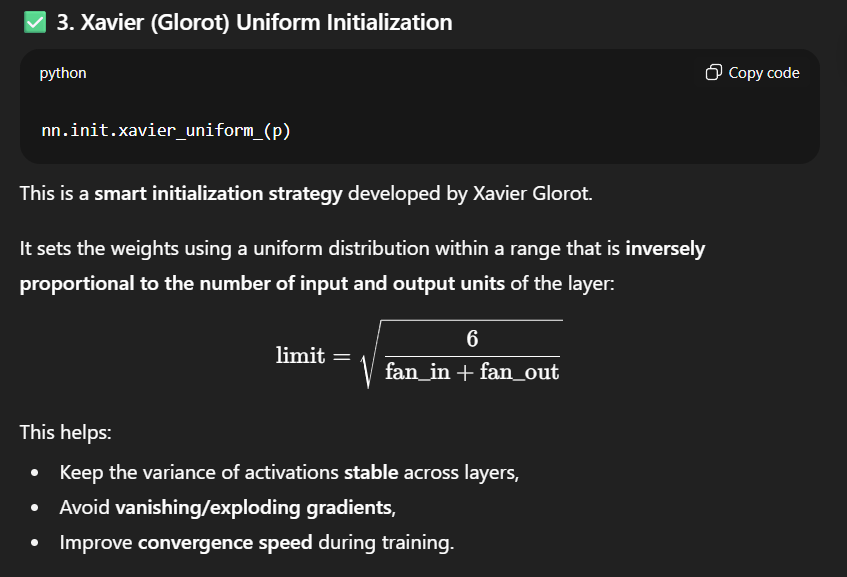

#### **Creating Custom Dataset**

##### **Purpose of the BilingualDataset Class**
This custom PyTorch Dataset prepares paired bilingual sequences (source and target) for training a Transformer model. It:

i) Tokenizes source and target sentences.  
ii) Pads sequences to a fixed length.  
iii) Adds special tokens ([SOS], [EOS], [PAD]).  
iv) Returns encoder_input, decoder_input, label, and appropriate masks.

In [204]:
import torch 
import torch.nn as nn 
from torch.utils.data import Dataset

In [205]:
class BilingualDataset(Dataset):

    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len):
        super().__init__()

        self.ds = ds  # Raw Dataset 
        self.tokenizer_src = tokenizer_src  # Tokenizer from src lang
        self.tokenizer_tgt = tokenizer_tgt  # Tokenizer from tgt lang
        self.src_lang = src_lang  # Lang. code for src lang
        self.tgt_lang = tgt_lang  # Lang. code for tgt lang
        self.seq_len = seq_len    # Fixed Max Sequence Length for both encoder & decoder

        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64) # Converts [SOS] token from tgt tokenizer to its ID & wraps in the 1-D Tensor
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)

    def __len__(self):
        return len(self.ds)
    
    
    def __getitem__(self, idx):

        # Load Source & target Sentence
        src_target_pair = self.ds[idx]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Converting the Text into tokens using HuggingFace Library
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids  # .encode() returns an Encoding Object
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids  # .ids - extracts raw list of token IDs

        # Calculating req. Padding 
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2  # -2 as we want to save 2 slots in encoder - [SOS], [EOS]
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1  # -1 as we want to save 1 slot in decoder - [SOS]

        # Make sure the no. of padding tokens is not -ve. If it is then the sentence is too long
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError("Sentence is too Long")
        
        # Creating Encoder Input & Adding [SOS] & [EOS] Token
        encoder_input = torch.cat([
            self.sos_token,
            torch.tensor(enc_input_tokens, dtype=torch.int64),  # Tokenized Source sentence into a tensor
            self.eos_token,
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64),  # Creates a padding tensor to fill up remaining space
        ], dim=0) 

        # Creating Decoder Input & Adding [SOS]
        decoder_input = torch.cat([
            self.sos_token,
            torch.tensor(dec_input_tokens, dtype=torch.int64),
            torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
        ], dim=0)

        # Creating Label (Decoder Output)
        label = torch.cat([
            torch.tensor(dec_input_tokens, dtype=torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64),
        ], dim=0)

        # Double Checking that the size of the tensors are same as seq_len
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            "encoder_input": encoder_input,  # Final Encoded Input (seq_len)
            "decoder_input": decoder_input,  # Final Decoder Input (seq_len)
            "encoder_mask" : (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),  # Encoder Mask (Ignore Padding TOkens) - (1,1,seq_len) [Same as MultiHead Attention]
            "decoder_mask" : (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),  # Decoder Mask (Ignore Padding Tokens) 
            "label" : label,
            "src_text" : src_text,
            "tgt_text" : tgt_text,
        }

**Causal Mask-** ensures that when predicting token i, the model can only attend to tokens ≤ i — not future tokens thus avoiding Data Leakage

In [206]:
def causal_mask(size):
    mask = torch.triu(torch.ones((1,size,size)), diagonal=1).type(torch.int)
    return mask==0

#### **Goal- Transformer from Scratch for Machine Translation**

Building a Transformer model from scratch for a machine translation task (e.g., English ➝ Italian). The focus is to build and train the Transformer without relying on pre-built models like BERT or T5, while still using external tools for data and tokenization.

Dataset Used – Opus Books  
A bilingual dataset available on Hugging Face. It contains pairs of sentences (e.g., one in English, one in Italian).

Used the "opus_books" dataset via datasets.load_dataset() method from Hugging Face.

##### **Setting Up Configurations for the Transformer Model**

In [207]:
from pathlib import Path 

# This func. returns a configuration dictionary that centralizes all imp. hyperparameters & file paths needed for your transformer training pipeline
def get_config():   
    return {
        "batch_size": 8,
        "num_epochs": 20,
        "lr": 10**-4,
        "seq_len": 350,
        "d_model": 512,
        "datasource": 'opus_books',
        "lang_src": "en",
        "lang_tgt": "it",
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "preload": "latest",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel"
    }

In [208]:
def get_weights_file_path(config, epoch: str):  # Func. returns the full path to a model weights file for a specifc epoch

    model_folder = f"{config['datasource']}_{config['model_folder']}" # Creates a folder name by combining dataset source & model folder
    model_filename = f"{config['model_basename']}{epoch}.pt"  # Genreates Filename using base name & epoch 'tmodel_5.pt'
    return str(Path('.')/ model_folder/ model_filename)  # Builds the Full File Path

In [209]:
# Func. Finds the most recent model weights file in the directory

def latest_weights_file_path(config):
    model_folder = f"{config['datasource']}_{config['model_folder']}"
    model_filename = f"{config['model_basename']}*"
    weights_files = list(Path(model_folder).glob(model_filename))

    if len(weights_files) == 0:
        return None
    
    weights_files.sort()
    return str(weights_files[-1])

##### **What is a tokenizer?**
A tokenizer converts raw sentences into tokens (words or subwords), and then maps them to unique integer IDs. These are fed into the model via embeddings.

🔹 Type of tokenizer used:
Word-level tokenizer (simplest form): splits on whitespace.  
Implemented using Hugging Face’s tokenizers library.

🔸 Special Tokens Used:  
<unk> (unknown words)  
<pad> (padding)  
<sos> (start of sentence)  
<eos> (end of sentence)  
These help handle sequence lengths and training dynamics in the Transformer.

In [210]:
from torch.utils.data import Dataset, DataLoader, random_split

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

from pathlib import Path

In [211]:
# This function iterates through a dataset (ds) and yields (i.e., lazily returns) only the sentence in the specified language (lang) from the translation pair.

def get_all_sentences(ds, lang):  # ds=datatset, lang=language
    for item in ds:
        yield item['translation'][lang]  

In [212]:
def get_or_build_tokenizer(config, ds, lang):
    tokenizer_path = Path(config['tokenizer_file'].format(lang))  # Constructs the file path where the tokenizer should be saved or loaded from.

    if not Path.exists(tokenizer_path):
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))  # Creates a word-level tokenizer with UNK token
        tokenizer.pre_tokenizer = Whitespace()  # Tokenizer splits on Whitespaces
        trainer =  WordLevelTrainer(special_tokens=["[UNK]", "[PAD]", "[SOS]", "[EOS]"], min_frequency=2) # Creates special tokens & includes words that appear atleast 2
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)  # Feeds all sentences in the target lang to the tokenizer for training
        tokenizer.save(str(tokenizer_path))  # Saves the trained tokenizer
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))  # If Tokenizer File exists, loads it from disk
    
    return tokenizer

In [213]:
def get_ds(config):
    # Contains only train split, will divide manually 
    ds_raw = load_dataset(f"{config['datasource']}", f"{config['lang_src']}-{config['lang_tgt']}", split='train') # Load the dataset

    tokenizer_src = get_or_build_tokenizer(config, ds_raw, config['lang_src'])  # Contains Source Lang. Tokens
    tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config['lang_tgt'])  # Target Lang. tokens

    # Split Dataset into Train & Validation
    train_ds_size = int(0.9 * len(ds_raw))  # 90% Training
    val_ds_size = len(ds_raw) - train_ds_size  # 10% Validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])  # Config will be defined later, Dynamically Designed as of now
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Find the maximum length of each sentence in source & target sequence
    max_len_src = 0
    max_len_tgt = 0

    for item in ds_raw:
        src_ids = tokenizer_src.encode(item["translation"][config['lang_src']]).ids
        tgt_ids = tokenizer_tgt.encode(item["translation"][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    
    print(f"Max. Length of Input Source: {max_len_src}")
    print("Max. Length of target sequence: ", max_len_tgt)

    
    train_dataloader = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt


In [214]:
# This func. is a convenience wrapper that creates & returns a Transformer Model 
# using config parameters & vocab sizes

def get_model(config, vocab_src_len, vocab_tgt_len):
    model = build_transformer(
        vocab_src_len,
        vocab_tgt_len,
        config['seq_len'],
        config['seq_len'],
        d_model = config["d_model"]
    )
    
    return model

#### **Training Loop For the Model**

In [215]:
import sys
print(sys.executable)

!{sys.executable} -m pip install tensorboard  # Installs tensorboard in the current Python environment


c:\Users\Aryan\AppData\Local\Programs\Python\Python312\python.exe



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [216]:
from torch.utils.tensorboard import SummaryWriter  # Tracks the training stats (visually Monitor Training Process)
from tqdm import tqdm  # Shows a Progress Bar while Processing each batch in Epoch
import warnings

In [219]:
def train_model(config):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using Device: ", device)
    
    Path(f"{config['datasource']}_{config['model_folder']}").mkdir(parents=True, exist_ok=True)  # Ensures that the weights saved actually exists

    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt= get_ds(config)
    model = get_model(config, tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)

    # TensorBoard
    writer = SummaryWriter(config['experiment_name'])  # Tracks Training Stats

    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

    # Resuming Training from Saved Weights (Loads prev. model state) or if not then trains from scratch
    initial_epoch = 0  # Keeps track of which epoch starting from
    global_step = 0  # Keeps track of total batches processed

    preload = config['preload']  # Reads from config whether you're preloading a model ("latest = last checkpoint, 5= from epoch 5, None= Start from Scratch")

    model_filename = (
        latest_weights_file_path(config)
        if preload == "latest"  # Latest .pt file
        else get_weights_file_path(config, preload)  # Loads particular epoch
        if preload
        else None  # trains from scratch
    )

    if model_filename:
        print(f'Preloading Model {model_filename}')
        state = torch.load(model_filename)

        # Restoring
        model.load_state_dict(state['model_state_dict'])  # Sets the model weights
        initial_epoch = state['epoch'] + 1  # Resumes training from next epoch
        optimizer.load_state_dict(state['optimizer_state_dict'])  # Sets Optimizer Momentum
        global_step = state['global_step']  # Continues where the logger left off

    else:
        print("No Model to Preload, starting from Scratch")

    loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device) 
    # Ignores Loss Calculation on Padding & label_smoothing prevents model overconfident distributes 10% Score among other tokens


    # Training Loop 
    for epoch in range(initial_epoch, config['num_epochs']):
        torch.cuda.empty_cache()
        model.train()

        batch_iterator = tqdm(train_dataloader, desc=f'Processing Epoch {epoch: 02d}')
        # Creating the Tensors & Passing to the GPU
        for batch in batch_iterator:

            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            # Run the Tensors through the Encoder, Decoder, Projection_layer (Forward Propagation)
            encoder_output = model.encode(encoder_input, encoder_mask)  # Feeds the source sentence to the encoder & Returns contextualized embeddings for each token, Dim: (B, seq_len, d_model)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)  # Takes the encoder output + target sentence so far & Returns decoder hidden states for each token
            proj_output = model.project(decoder_output)

            # Compare the o/p with the label
            label = batch['label'].to(device)

            # Compute Loss by Comparing O/p vs labels (true o/p)
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))  # Flattening both o/p & label to apply loss func, Suppose:B = 8 (batch size),seq_len = 350,vocab_size = 32,000, Then proj_output has shape: (8, 350, 32000), .view(-1, 32000) turns it into: (8*350, 32000) = (2800, 32000)
            batch_iterator.set_postfix({"loss": f"{loss.item(): 6.3f}"})  # Updates the tqdm progress bar with the current batch loss.

            writer.add_scalar('train_loss', loss.item(), global_step) # records the scalar loss under the tag "train loss" at current global_step.
            writer.flush() # Forces the writer to immediately write the log to disk, Without it, logs may not appear until much later.

            # Backpropagate
            loss.backward()

            optimizer.step()
            optimizer.zero_grad(set_to_none = True)

            global_step += 1

        # Save the Model at the End of Each Epoch
        model_filename = get_weights_file_path(config, f"{epoch: 02d}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step
        }, model_filename)


In [220]:
if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    config = get_config()
    train_model(config)

Using Device:  cuda
Max. Length of Input Source: 309
Max. Length of target sequence:  274
No Model to Preload, starting from Scratch


Processing Epoch  0:   0%|          | 12/3638 [00:35<2:59:16,  2.97s/it, loss=9.341]


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
